In [7]:
import flopy as fp
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
import shapely
from flopy.utils.gridintersect import GridIntersect
import os
from osgeo import gdal

this notebook import and work with MNT (tif/grd) files in order to provide the top of the 1st layer and have a pseudo 3D model

In [32]:
model_dir = "working"
model_name="mnt_test"
exe_name="../../exe.mf6"
R_path="../data/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
MNT_path= "../../../../../MNT_50.tif"

Extract geographic data from the MNT with gdal

In [33]:
# extract corner coord of the mnt
R_mnt = gdal.Open(MNT_path)
mnt_infos=R_mnt.GetGeoTransform()
x0 = mnt_infos[0]+mnt_infos[1]/2
x1 = x0 + R_mnt.RasterXSize*mnt_infos[1]
y1 = mnt_infos[3]+mnt_infos[5]/2
y0 = y1 + R_mnt.RasterYSize*mnt_infos[5]

add basic parameters

In [34]:
Lx = x1-x0
Ly = y1-y0
nlay=1
ncol = 100
nrow = 100
delr = np.ones(ncol)*(Lx/ncol)
delc = np.ones(nrow)*(Ly/nrow)
botm = -100
top = 100
idomain = np.zeros((nrow*ncol))



Import the MNT (only tif at this moment)

In [35]:
# import a mnt and use it to
from PIL import Image
im = Image.open(MNT_path) # add path to MNT.tif

extract data into an array with numpy, assign None value where there's no data and retrieve MNT's resolution

In [36]:
imar = np.array(im)
imar[imar<=0]=None

#plt.figure(figsize=(10,10))
#plt.imshow(imar)
#plt.clim(-1,0)
#plt.colorbar()

ny,nx = imar.shape
dx = Lx/nx
dy = Ly/ny
a = pd.DataFrame(imar.reshape(imar.size))
a.describe() # look at some infos about the mnt

,0
count,522057.000000
mean,117.018318
std,135.098938
min,0.010000
25%,17.059999
50%,72.599998
75%,164.199997
max,1028.410034


Create a fake simulation pack in order to make some plots

In [37]:
simfake = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwffake = fp.mf6.ModflowGwf(simfake, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwffake, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

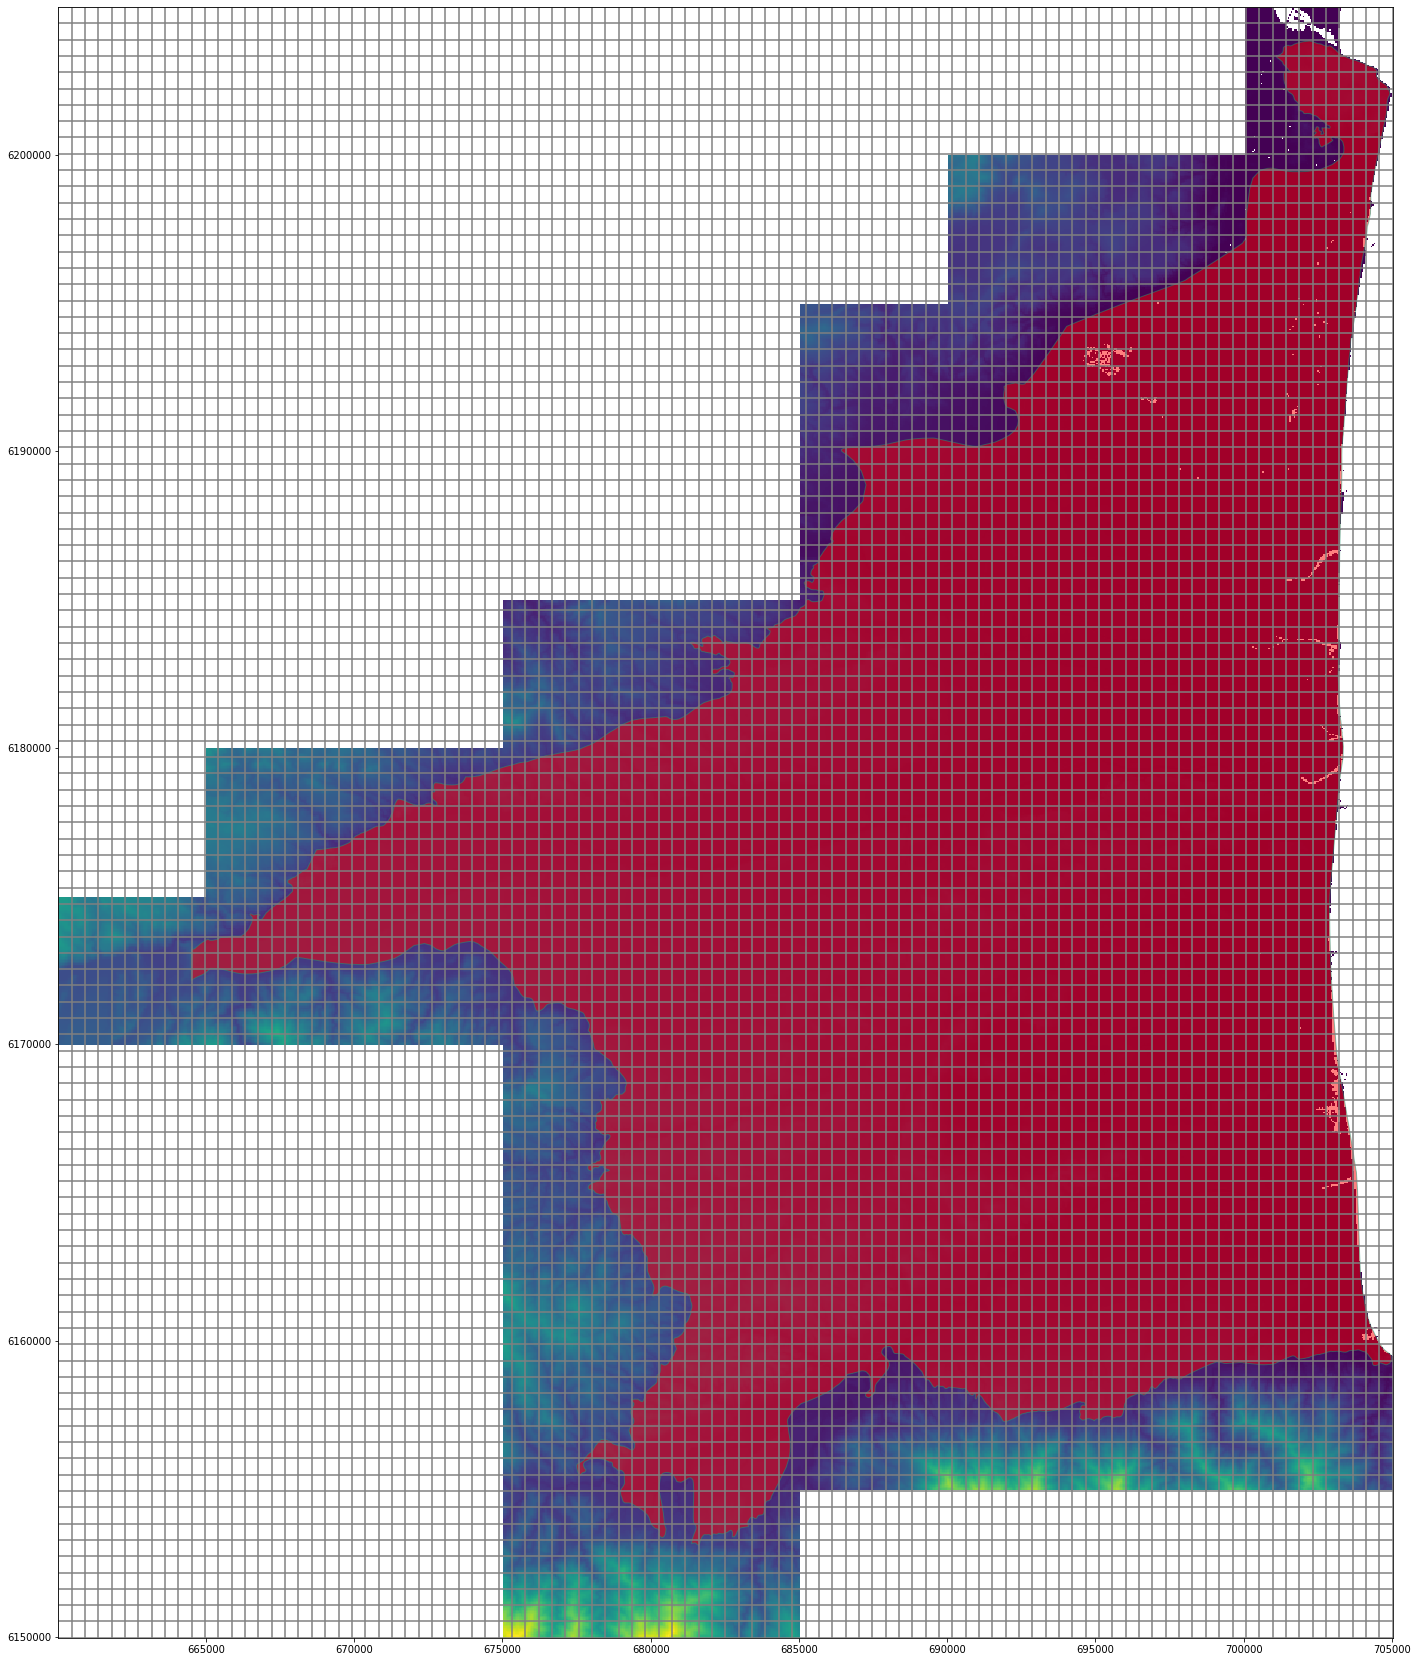

In [38]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(aspect='equal')
mm = fp.plot.PlotMapView(model=gwffake)
mm.plot_grid()
fp.plot.plot_shapefile(R_path,ax=ax,facecolor="Red",alpha=0.5)
ax.imshow(imar,extent=(x0,x1,y0,y1))

### this function reduce the resolution of an image (image should be an array of a form (nx,ny)) to the size (nrow, ncol)
P.S nodata must be declared as "None" dtype

In [39]:
def Imreduction (imar, nrow, ncol):
    #first define the ratio between the given and the desired resolution in x and y
    facR=imar.shape[0]/nrow
    facC=imar.shape[1]/ncol
    
    # go through the entire grid (nrow,ncol) and use the mean of all the values in the array image
    # in a specific cell of the grid (i,o)
    new_imar=[]
    for i in range(nrow):
        for o in range(ncol):
            new_val=np.nanmean(imar[np.round(i*facR).astype(int):np.round(i*facR+facR).astype(int),
                                    np.round(o*facC).astype(int):np.round(o*facC+facC).astype(int)])
            new_imar.append(new_val)
    
    # create an array of the new image array
    new_imar = np.array(new_imar)
    return new_imar.reshape(nrow,ncol)

In [43]:
new_imar = Imreduction(imar,nrow,ncol)

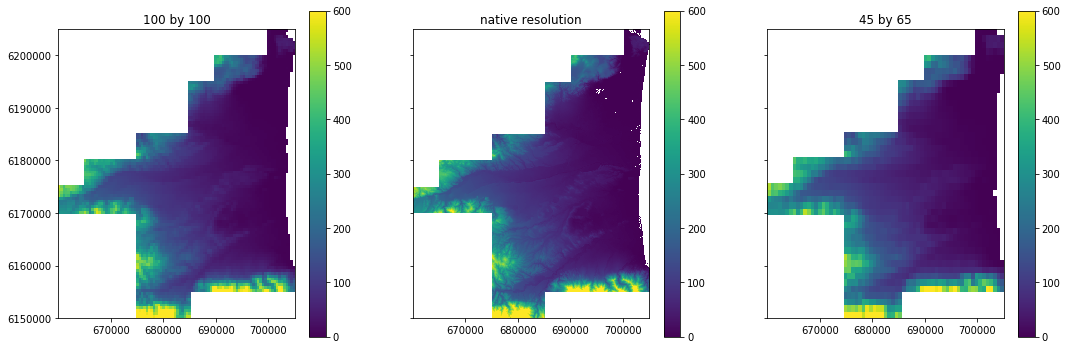

In [42]:
clim=(0,600)
fig,ax=plt.subplots(1,3,sharey=True,figsize=(18,6))

g=ax[0].imshow(new_imar,extent=(x0,x1,y0,y1))
fig.colorbar(g,ax=ax[0])
ax[0].set(title=("100 by 100"))
g.set_clim(clim)

h=ax[1].imshow(imar,extent=(x0,x1,y0,y1))
plt.colorbar(h,ax=ax[1])
ax[1].set(title=("native resolution"))
h.set_clim(clim)

j = ax[2].imshow(Imreduction(imar,45,65),extent=(x0,x1,y0,y1))
plt.colorbar(j,ax=ax[2])
ax[2].set(title=("45 by 65"))
j.set_clim(clim)

fill the NaN with 0

In [48]:
top = pd.DataFrame(new_imar).fillna(0)
top = np.array(top)

In [49]:
simfake = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwffake = fp.mf6.ModflowGwf(simfake, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwffake, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

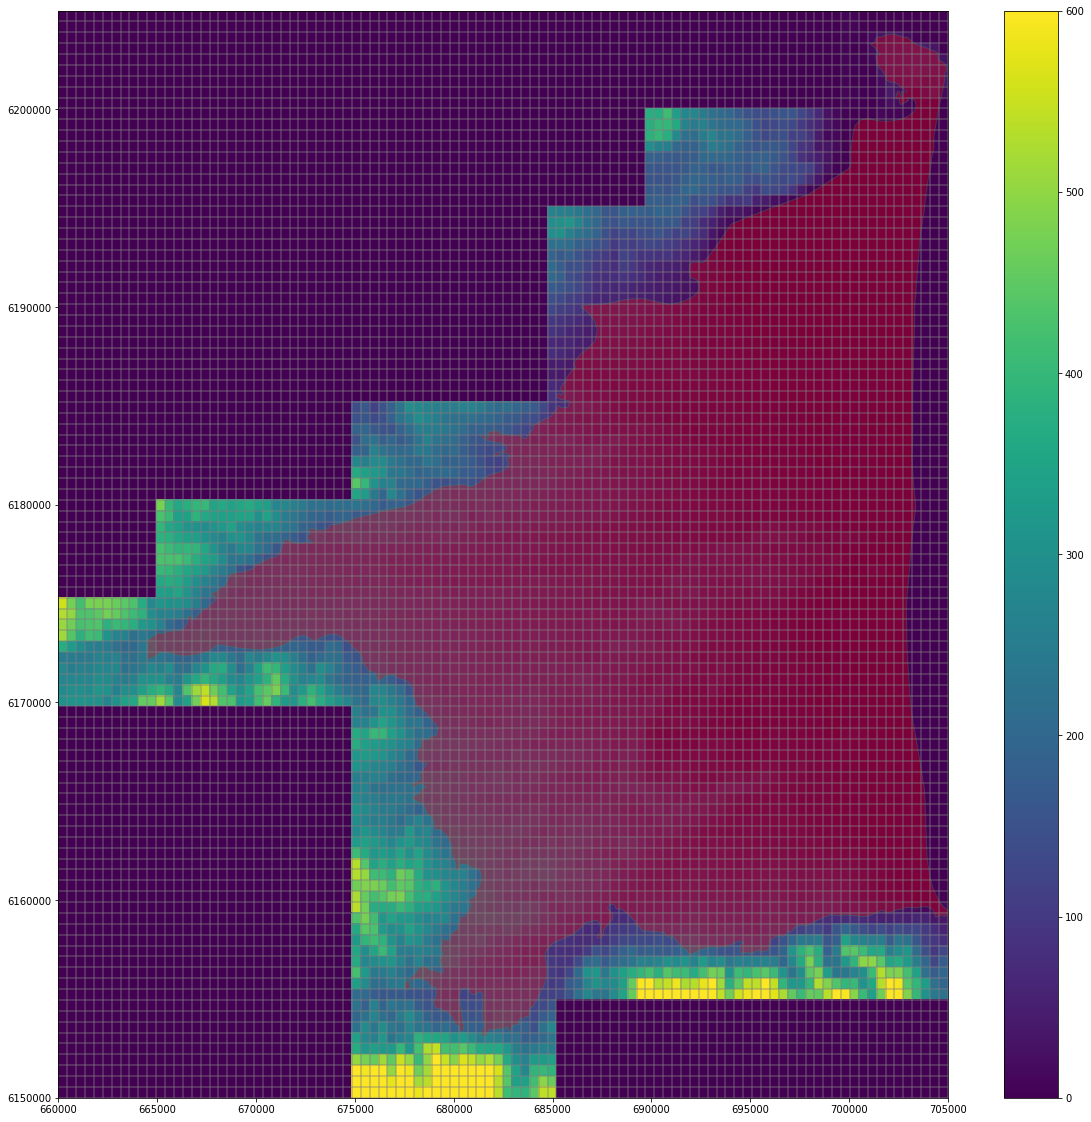

In [50]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(aspect='equal')
mm = fp.plot.PlotMapView(model=gwffake)
b = gwffake.dis.top.array
mm.plot_grid(alpha=0.5)
quad=mm.plot_array(b)
plt.colorbar(quad)
quad.set_clim(clim)
fp.plot.plot_shapefile(R_path,ax=ax,facecolor="Red",alpha=0.3)

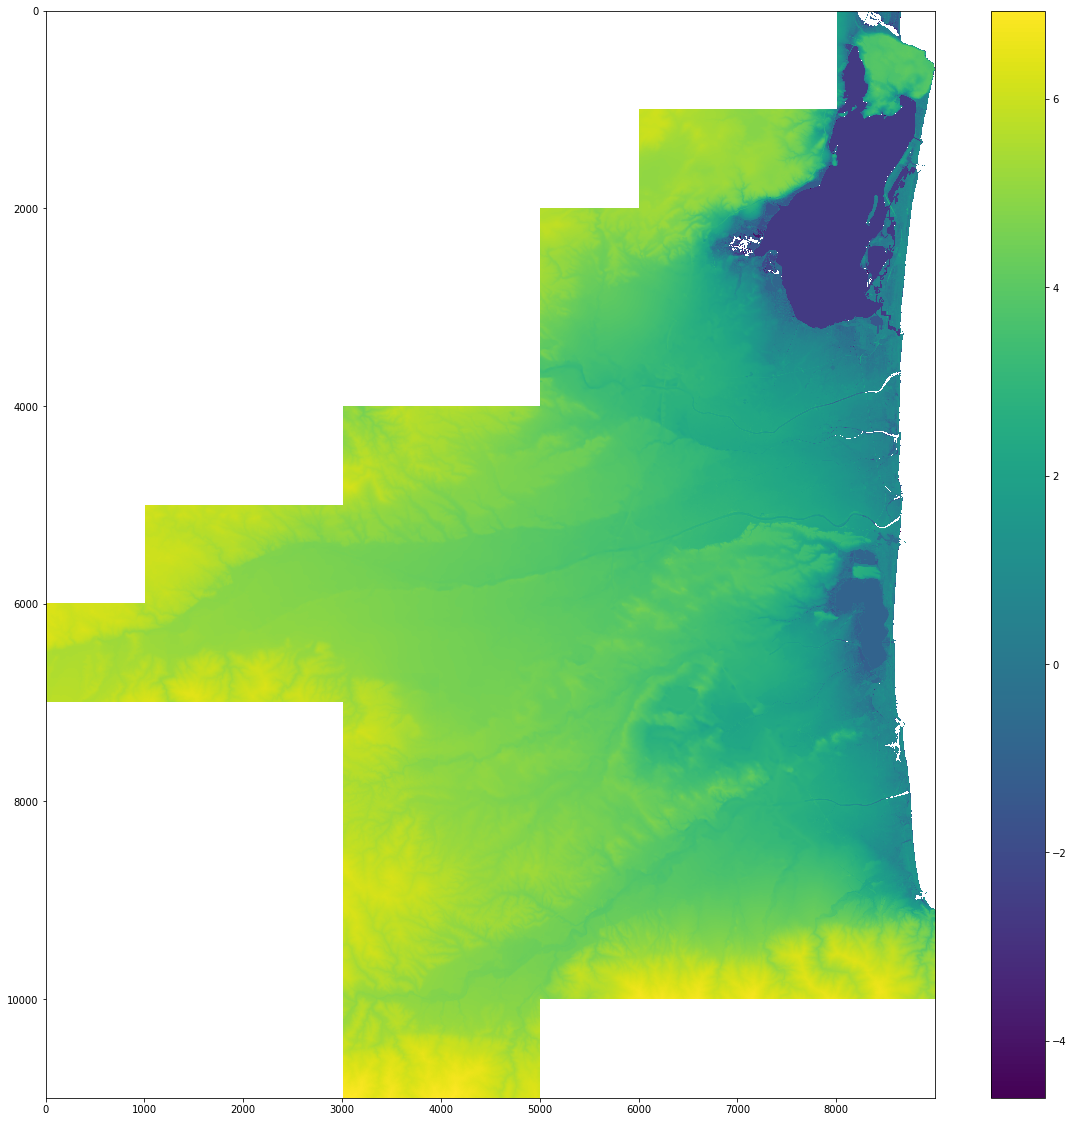

In [51]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(aspect='equal')
a=plt.imshow(np.log(imar))
plt.colorbar(a)